In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels as sm
import math
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, confint_proportions_2indep, power_proportions_2indep
import numpy as np
import statsmodels.stats.api as sms
from statsmodels.stats.power import NormalIndPower


In [2]:
import random

# Function to set the random seed
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# Set the seed for reproducibility
set_seed(seed=40)

In [3]:
def simulate_hiring_outcomes(num_men, num_women,
                                men_qualified_rate, women_qualified_rate,
                                qualified_men_hiring_rate, qualified_women_hiring_rate,
                                unqualified_men_hiring_rate, unqualified_women_hiring_rate):
    """
    Simulate the hiring outcomes for a population of men and women.

    Parameters:
    - num_men: Number of men in the population
    - num_women: Number of women in the population
    - men_qualified_rate: Proportion of men who are actually qualified
    - women_qualified_rate: Proportion of women who are actually qualified
    - qualified_men_hiring_rate: Proportion of qualified men who are hired
    - qualified_women_hiring_rate: Proportion of qualified women who are hired
    - unqualified_men_hiring_rate: Proportion of unqualified men who are hired
    - unqualified_women_hiring_rate: Proportion of unqualified women who are hired

    Returns:
    - DataFrame containing the group label, prediction (hiring decision), and true label (qualification) for each individual
    """

    # Generate true labels for qualification
    men_labels = np.random.choice([1, 0], size=num_men, p=[men_qualified_rate, 1-men_qualified_rate])
    women_labels = np.random.choice([1, 0], size=num_women, p=[women_qualified_rate, 1-women_qualified_rate])

    # Initialize predictions with 0 (not hired)
    men_predictions = np.zeros(num_men)
    women_predictions = np.zeros(num_women)

    # Get indices of qualified and unqualified men and women
    qualified_men_indices = np.where(men_labels == 1)[0]
    qualified_women_indices = np.where(women_labels == 1)[0]

    unqualified_men_indices = np.where(men_labels == 0)[0]
    unqualified_women_indices = np.where(women_labels == 0)[0]

    # Hire qualified men and women based on specified hiring rates
    num_qualified_men_hired = int(len(qualified_men_indices) * qualified_men_hiring_rate)
    num_qualified_women_hired = int(len(qualified_women_indices) * qualified_women_hiring_rate)

    men_predictions[np.random.choice(qualified_men_indices, num_qualified_men_hired, replace=False)] = 1
    women_predictions[np.random.choice(qualified_women_indices, num_qualified_women_hired, replace=False)] = 1

    # Hire unqualified men and women based on specified hiring rates
    num_unqualified_men_hired = int(len(unqualified_men_indices) * unqualified_men_hiring_rate)
    num_unqualified_women_hired = int(len(unqualified_women_indices) * unqualified_women_hiring_rate)

    men_predictions[np.random.choice(unqualified_men_indices, num_unqualified_men_hired, replace=False)] = 1
    women_predictions[np.random.choice(unqualified_women_indices, num_unqualified_women_hired, replace=False)] = 1

    # Create DataFrame
    data = {
        'group': ['men'] * num_men + ['women'] * num_women,
        'true_label': np.concatenate([men_labels, women_labels]),
        'prediction': np.concatenate([men_predictions, women_predictions])
    }

    return pd.DataFrame(data)

def plot_hiring_outcomes(df):
    # Define labels for the pie charts
    labels = ['Hired', 'Not Hired']
    alpha = 0.7

    # Filter the DataFrame for each group and outcome
    qualified_men = df[(df['group'] == 'men') & (df['true_label'] == 1)]
    qualified_women = df[(df['group'] == 'women') & (df['true_label'] == 1)]
    unqualified_men = df[(df['group'] == 'men') & (df['true_label'] == 0)]
    unqualified_women = df[(df['group'] == 'women') & (df['true_label'] == 0)]

    # Get the counts for the pie charts, ensuring both 'Hired' and 'Not Hired' categories are present
    q_men_counts = qualified_men['prediction'].value_counts().reindex([1, 0], fill_value=0).values
    q_women_counts = qualified_women['prediction'].value_counts().reindex([1, 0], fill_value=0).values
    uq_men_counts = unqualified_men['prediction'].value_counts().reindex([1, 0], fill_value=0).values
    uq_women_counts = unqualified_women['prediction'].value_counts().reindex([1, 0], fill_value=0).values

    # Create a figure with four subplots (2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Function to format the autopct argument
    def format_autopct(pct):
        return f'{int(round(pct))}%'

    # Plot pie chart for qualified men
    axes[0, 0].pie(q_men_counts, labels=labels, autopct=format_autopct, startangle=90, colors=['lightgreen', 'lightcoral'], wedgeprops={"alpha": alpha})
    axes[0, 0].set_title('Qualified Men', fontweight='bold')

    # Plot pie chart for qualified women
    axes[0, 1].pie(q_women_counts, labels=labels, autopct=format_autopct, startangle=90, colors=['lightgreen', 'lightcoral'], wedgeprops={"alpha": alpha})
    axes[0, 1].set_title('Qualified Women', fontweight='bold')

    # Plot pie chart for unqualified men
    axes[1, 0].pie(uq_men_counts, labels=labels, autopct=format_autopct, startangle=90, colors=['lightblue', 'lightgray'], wedgeprops={"alpha": alpha})
    axes[1, 0].set_title('Unqualified Men', fontweight='bold')

    # Plot pie chart for unqualified women
    axes[1, 1].pie(uq_women_counts, labels=labels, autopct=format_autopct, startangle=90, colors=['lightblue', 'lightgray'], wedgeprops={"alpha": alpha})
    axes[1, 1].set_title('Unqualified Women', fontweight='bold')

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

def plot_sample_selection_rates(sample_metrics, pop_men_sel_rate, pop_women_sel_rate):
  # Convert sample_metrics to a DataFrame

  # Creating the histogram for both 'men_sel_rate' and 'women_sel_rate'
  plt.figure(figsize=(8, 6))

  # Histogram for men
  plt.hist(sample_metrics['men_selection_rate'], bins=20, alpha=0.5, edgecolor='black', label='Men Selection Rate')

  # Histogram for women
  plt.hist(sample_metrics['women_selection_rate'], bins=20, alpha=0.5, edgecolor='black', label='Women Selection Rate')

  # Add a vertical line at the population mean for men
  plt.axvline(pop_men_sel_rate, color='blue', linestyle='dashed', linewidth=2, label=f"Men Population Rate: {pop_men_sel_rate:.2f}")

  # Add a vertical line at the population mean for women
  plt.axvline(pop_women_sel_rate, color='orange', linestyle='dashed', linewidth=2, label=f"Women Population Rate: {pop_women_sel_rate:.2f}")


  # Adding labels and title
  plt.xlabel('Selection Rate')
  plt.ylabel('Frequency')
  plt.title('Histogram of Selection Rates for Men and Women')
  plt.legend()

  # Display the histogram
  plt.show()

def plot_p_values(sample_stats, metric_name='sel_rate_thresh', non_inferiority=False):

  if non_inferiority:
    p_vals = [sample['p_noninf'] for sample in audit_stats]
    print(f"Number of significant p-vals for {metric_name}: {len([p_noninf for p_noninf in p_vals if p_noninf < 0.05])}. Number of non-significant p-vals for {metric_name}: {len([p_noninf for p_noninf in p_vals if p_noninf if p_noninf >= 0.05])}")

  else:
    p_vals = [sample['p'] for sample in audit_stats]
    print(f"Number of significant p-vals for {metric_name}: {len([p for p in p_vals if p < 0.05])}. Number of non-significant p-vals for {metric_name}: {len([p for p in p_vals if p >= 0.05])}")


  #print(f"Number of significant p-vals for {metric_name}: {len([p for p in p_vals if p < 0.05])}. Number of non-significant p-vals for {metric_name}: {len([p for p in p_vals if p >= 0.05])}")

  # Creating the histogram for p values for simulated samples
  plt.figure(figsize=(8, 6))
  plt.hist(p_vals, bins=20, edgecolor='black')
  # Add a vertical line at the population mean
  plt.axvline(0.05, color='red', linestyle='dashed', linewidth=2, label=f'significance: p<0.05')


  # Adding labels and title
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of P Values for Hypothesis Test on {metric_name}')
  plt.legend()

  # Display the histogram
  plt.show()

def plot_hist_selection_rate_difference(audit_metrics_df, pop_sel_rate_difference, sel_rate_thresh=0.2, ):

  sel_rate_diff = audit_metrics_df['men_selection_rate']-audit_metrics_df['women_selection_rate'].to_list()

  # Creating the histogram for both 'men_sel_rate' and 'women_sel_rate'
  plt.figure(figsize=(8, 6))

  # Histogram for men
  plt.hist(sel_rate_diff, bins=20, alpha=1, edgecolor='black', label='Selection Rate Difference')


  # Add a vertical line at the population mean for men
  if sel_rate_thresh:
    plt.axvline(sel_rate_thresh, color='red', linestyle='dashed', linewidth=2, label=f"Selection Rate Threshold: {sel_rate_thresh:.2f}")
  plt.axvline(pop_sel_rate_difference, color='green', linestyle='dashed', linewidth=2, label=f"Population Selection Rate Difference: {pop_sel_rate_difference:.2f}")


  # Adding labels and title
  plt.xlabel('Selection Rate')
  plt.ylabel('Frequency')
  plt.title('Histogram of Difference in Selection Rates between Men and Women')
  plt.legend()

  # Display the histogram
  plt.show()
  if sel_rate_thresh:
    print(f"Number of samples with a difference greater than or equal to the threshold of {sel_rate_thresh}: {len([val for val in sel_rate_diff if val >= sel_rate_thresh])}")


def calculate_metrics(df):
    """
    Calculate the tp, tn, fp, fn, and overall selection rate for men and women.

    Parameters:
    - df: DataFrame containing the group label, prediction (hiring decision), and true label (qualification)

    Returns:
    - Flat dictionary containing the metrics for men and women
    """

    metrics = {}

    # Calculate metrics for men
    men_df = df[df['group'] == 'men']

    metrics['men_tp'] = len(men_df[(men_df['prediction'] == 1) & (men_df['true_label'] == 1)])
    metrics['men_tn'] = len(men_df[(men_df['prediction'] == 0) & (men_df['true_label'] == 0)])
    metrics['men_fp'] = len(men_df[(men_df['prediction'] == 1) & (men_df['true_label'] == 0)])
    metrics['men_fn'] = len(men_df[(men_df['prediction'] == 0) & (men_df['true_label'] == 1)])
    metrics['men_selection_rate'] = len(men_df[men_df['prediction'] == 1]) / len(men_df)

    # Calculate metrics for women
    women_df = df[df['group'] == 'women']

    metrics['women_tp'] = len(women_df[(women_df['prediction'] == 1) & (women_df['true_label'] == 1)])
    metrics['women_tn'] = len(women_df[(women_df['prediction'] == 0) & (women_df['true_label'] == 0)])
    metrics['women_fp'] = len(women_df[(women_df['prediction'] == 1) & (women_df['true_label'] == 0)])
    metrics['women_fn'] = len(women_df[(women_df['prediction'] == 0) & (women_df['true_label'] == 1)])
    metrics['women_selection_rate'] = len(women_df[women_df['prediction'] == 1]) / len(women_df)

    metrics['difference_selection_rate']=metrics['men_selection_rate']-metrics['women_selection_rate']

    return metrics

def simulate_audit(df, men_sample_size, women_sample_size, n_iterations=1, sel_rate_thresh=None, perform_non_inferiority=False):
    """
    Simulate an audit by sampling a specified number of men and women from the population,
    and calculate the tp, tn, fp, fn, and overall selection rate for the sample.
    Perform this process multiple times and aggregate the results into a DataFrame.

    Parameters:
    - df: DataFrame containing the group label, prediction (hiring decision), and true label (qualification)
    - men_sample_size: Number of men to sample
    - women_sample_size: Number of women to sample
    - n_iterations: Number of times to repeat the sampling and metrics calculation

    Returns:
    - DataFrame containing the aggregated metrics for each iteration
    """

    # List to hold metrics for each iteration
    metrics= []
    stats = []

    for _ in range(n_iterations):
        # Sample the specified number of men and women
        men_sample = df[df['group'] == 'men'].sample(n=men_sample_size, replace=False)
        women_sample = df[df['group'] == 'women'].sample(n=women_sample_size, replace=False)

        # Combine the sampled men and women into a single DataFrame
        sample_df = pd.concat([men_sample, women_sample])

        # Calculate metrics for the sample using the calculate_metrics function
        sample_metrics = calculate_metrics(sample_df)

        # Append the metrics to the list
        metrics.append(sample_metrics)
        # Perform the two-sample z-test for proportions
        # for one sided, we are testing H0: men_sel_rate - women_sel_rate <= proportion_diff, H1: men_sel_rate - women_sel_rate > proportion_diff
        #one sided test
        men_success = sample_metrics["men_tp"]+sample_metrics["men_fp"]
        women_success =  sample_metrics["women_tp"]+sample_metrics["women_fp"]

        # Proportions of success
        men_p = men_success / men_sample_size
        women_p = women_success / women_sample_size

        # Calculate Cohen's h using statsmodels
        effect_size = proportion_effectsize(men_p, women_p)

        # Calculate power
        power = NormalIndPower().solve_power(effect_size=effect_size, nobs1=men_sample_size, alpha=0.05, ratio=women_sample_size/men_sample_size, alternative='larger')

        if sel_rate_thresh:
          power = NormalIndPower().solve_power(effect_size=effect_size, nobs1=men_sample_size, alpha=0.05, ratio=women_sample_size/men_sample_size, alternative='larger')
          stat, p_value = proportions_ztest([men_success, women_success], [men_sample_size, women_sample_size], value=sel_rate_thresh, alternative='larger')
        else:
          stat, p_value = proportions_ztest([men_success, women_success], [men_sample_size, women_sample_size], alternative='larger')

        if perform_non_inferiority:
          # Perform the one-sided z-test where the null hypothesis is that men's success rate is higher
          if not sel_rate_thresh:
            non_inferiority_margin = 0.05  # The acceptable difference margin
          else:
            non_inferiority_margin = sel_rate_thresh
          stat, p_value = proportions_ztest([men_success, women_success],
                                            [men_sample_size, women_sample_size],
                                            value=non_inferiority_margin,
                                            alternative='smaller')
          stats.append({"sample_num": n_iterations, "z_stat": stat, "p": p_value, "cohens_h":effect_size, "power":power, "z_stat_noninf": stat, "p_noninf": p_value})
        else:
          stats.append({"sample_num": n_iterations, "z_stat": stat, "p": p_value, "cohens_h":effect_size, "power":power})

    # Convert the list of dictionaries to a DataFrame
    metrics_df = pd.DataFrame(metrics)

    return metrics_df, stats


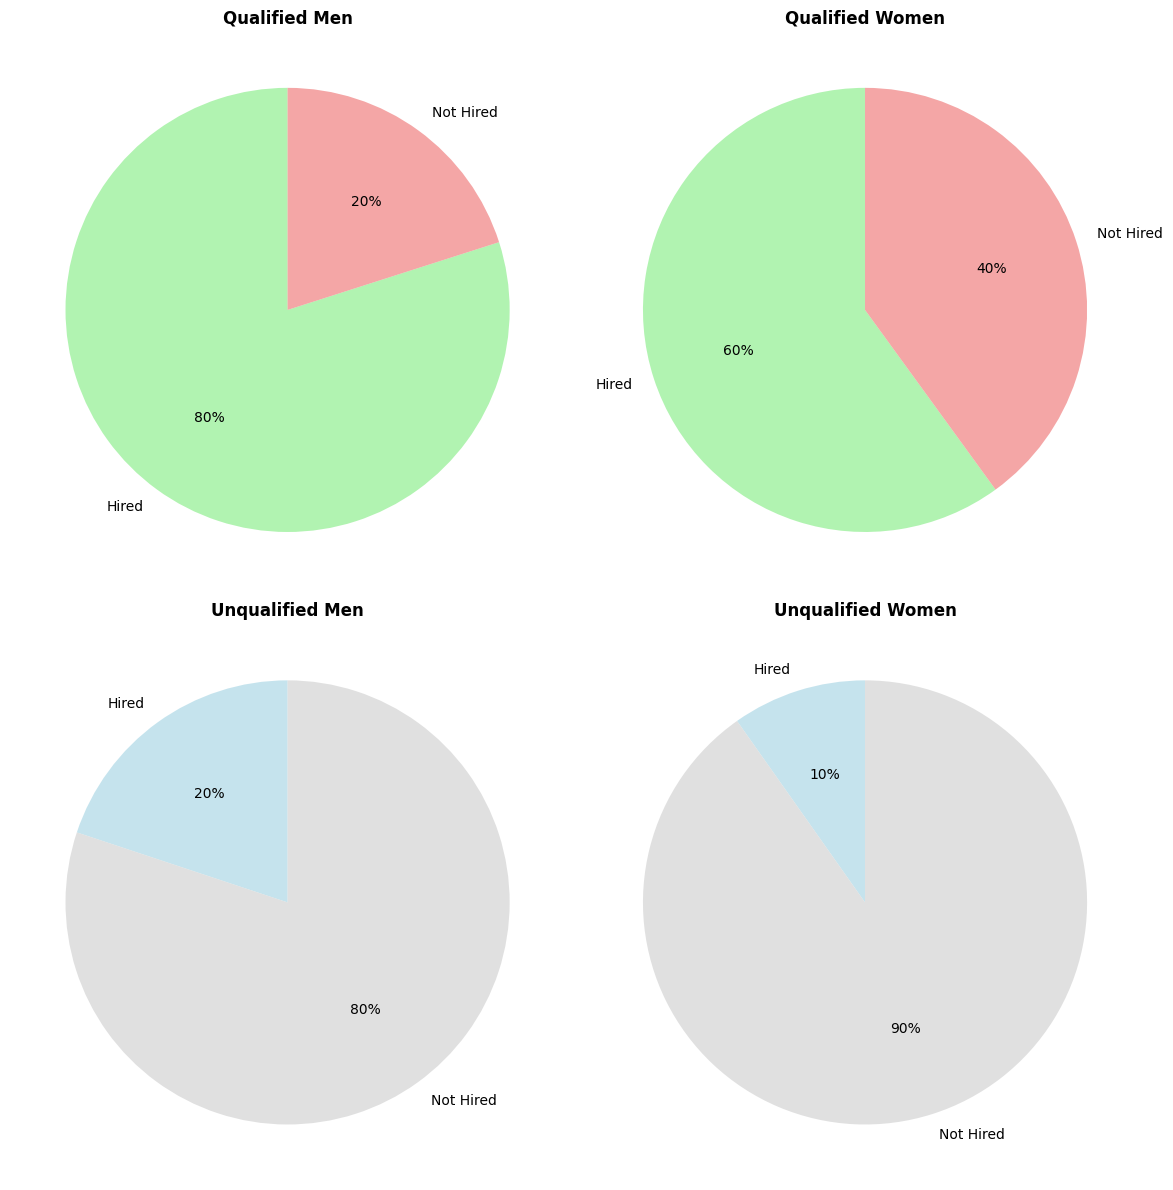

{'men_tp': 247, 'men_tn': 153, 'men_fp': 38, 'men_fn': 62, 'men_selection_rate': 0.57, 'women_tp': 165, 'women_tn': 203, 'women_fp': 22, 'women_fn': 110, 'women_selection_rate': 0.374, 'difference_selection_rate': 0.19599999999999995}


In [4]:
bias_population= simulate_hiring_outcomes(
    num_men=500,
    num_women=500,
    men_qualified_rate=0.6,
    women_qualified_rate=0.6,
    qualified_men_hiring_rate=0.8,
    qualified_women_hiring_rate=0.6,
    unqualified_men_hiring_rate=0.2,
    unqualified_women_hiring_rate=0.1
)

plot_hiring_outcomes(bias_population)
bias_population_metrics = calculate_metrics(bias_population)
print(bias_population_metrics)

In [5]:
def simulate_audit(df, men_sample_size, women_sample_size, n_iterations=1, sel_rate_thresh=None, perform_non_inferiority=False, calculate_sample_size=True, desired_power=0.8):
    """
    Simulate an audit by sampling men and women from the population,
    and calculate the selection metrics for each sample. Optionally, perform
    non-inferiority testing and calculate sample sizes.

    Parameters:
    - df: DataFrame containing group labels, predictions, and true labels
    - men_sample_size: Number of men to sample
    - women_sample_size: Number of women to sample
    - n_iterations: Number of iterations to perform the sampling and metric calculation
    - sel_rate_thresh: Optional threshold for selection rate difference
    - perform_non_inferiority: Boolean to perform a non-inferiority test
    - calculate_sample_size: Boolean to calculate sample sizes for the tests
    - desired_power: Desired power level for sample size calculation (default is 0.8)

    Returns:
    - DataFrame containing the aggregated metrics for each iteration
    - List of statistics including z-statistics, p-values, effect sizes, power calculations, and sample sizes
    """

    metrics_list = []
    stats_list = []

    # Function to calculate power
    def calculate_power(effect_size, nobs1, ratio, alpha=0.05, alternative='larger'):
        return NormalIndPower().solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha, ratio=ratio, alternative=alternative)

    for iteration in range(n_iterations):
        # Sample the specified number of men and women
        men_sample = df[df['group'] == 'men'].sample(n=men_sample_size, replace=False)
        women_sample = df[df['group'] == 'women'].sample(n=women_sample_size, replace=False)

        # Combine the sampled data
        sample_df = pd.concat([men_sample, women_sample])

        # Calculate metrics for the sample
        sample_metrics = calculate_metrics(sample_df)
        metrics_list.append(sample_metrics)

        # Calculate success counts and proportions
        men_success = sample_metrics["men_tp"] + sample_metrics["men_fp"]
        women_success = sample_metrics["women_tp"] + sample_metrics["women_fp"]
        men_p = men_success / men_sample_size
        women_p = women_success / women_sample_size

        print(f"sample_num is {iteration+1}")
        print(f"Selection rate difference: {men_p-women_p}")

        # Calculate standard effect size (Cohen's h) and power
        effect_size_standard = proportion_effectsize(men_p, women_p)
        print(f"effect size standard: {effect_size_standard}")

        power_standard = calculate_power(effect_size_standard, men_sample_size, women_sample_size / men_sample_size)
        print(f"power standard: {power_standard}")

        # Perform the z-test for proportions
        stat, p_value = proportions_ztest([men_success, women_success], [men_sample_size, women_sample_size],
                                          value=sel_rate_thresh, alternative='larger' if sel_rate_thresh else 'two-sided')
        print(f"z-stat: {stat}")
        print(f"p-value: {p_value}")

        # Optionally calculate sample size for standard test
        sample_size_standard = None

        if calculate_sample_size and effect_size_standard != 0:
          sample_size_standard = NormalIndPower().solve_power(effect_size=effect_size_standard, alpha=0.05,
                                                                power=desired_power, ratio=women_sample_size / men_sample_size, alternative='larger')

        # Non-inferiority test if requested
        stats = {
            "sample_num": iteration + 1,
            "z_stat": stat,
            "p": p_value,
            "cohens_h_standard": effect_size_standard,
            "power_standard": power_standard,
            "sample_size_standard": sample_size_standard
        }

        if perform_non_inferiority:
            non_inferiority_margin = sel_rate_thresh if sel_rate_thresh else 0.10
            adjusted_women_p = women_p - non_inferiority_margin
            print(f"Adjusted women p: {adjusted_women_p}")
            effect_size_noninf = proportion_effectsize(men_p, adjusted_women_p)
            print(f"Effect size noninf: {effect_size_noninf}")
            power_noninf = calculate_power(effect_size_noninf, men_sample_size, women_sample_size / men_sample_size, alternative='smaller')

            stat_noninf, p_value_noninf = proportions_ztest([men_success, women_success],
                                                            [men_sample_size, women_sample_size],
                                                            value=non_inferiority_margin, alternative='smaller')

            sample_size_noninf = None
            if calculate_sample_size and effect_size_noninf != 0:
                sample_size_noninf = NormalIndPower().solve_power(effect_size=effect_size_noninf, alpha=0.05,
                                                                  power=desired_power, ratio=women_sample_size / men_sample_size, alternative='smaller')

            stats.update({
                "z_stat_noninf": stat_noninf,
                "p_noninf": p_value_noninf,
                "cohens_h_noninf": effect_size_noninf,
                "power_noninf": power_noninf,
                "sample_size_noninf": sample_size_noninf
            })

        stats_list.append(stats)

    # Convert the list of metrics to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df, stats_list


In [6]:
sel_rate_thresh=None
women_sample_size = 100
men_sample_size = 100
# Simulate an audit with a sample of 100 men and 100 women, repeated 10 times
audit_metrics_df, audit_stats = simulate_audit(df=bias_population, men_sample_size=men_sample_size,
                                               women_sample_size=women_sample_size, n_iterations=100,
                                               sel_rate_thresh=sel_rate_thresh, perform_non_inferiority=True)

sample_num is 1
Selection rate difference: 0.26
effect size standard: 0.5261599602472913
power standard: 0.9810372558648232
z-stat: 3.677690873913362
p-value: 0.00023535494577535938
Adjusted women p: 0.26
Effect size noninf: 0.7430205634435514
sample_num is 2
Selection rate difference: 0.18
effect size standard: 0.3657401616486191
power standard: 0.8267295152479868
z-stat: 2.5709039506801905
p-value: 0.010143345475753258
Adjusted women p: 0.24000000000000002
Effect size noninf: 0.5868616250499332
sample_num is 3
Selection rate difference: 0.13
effect size standard: 0.2618251448507831
power standard: 0.5818114268273262
z-stat: 1.8459690064405705
p-value: 0.06489670579748036
Adjusted women p: 0.38
Effect size noninf: 0.4641803215357576
sample_num is 4
Selection rate difference: 0.21000000000000002
effect size standard: 0.4242555239181838
power standard: 0.9123049130846037
z-stat: 2.977151459192793
p-value: 0.002909402414962189
Adjusted women p: 0.32999999999999996
Effect size noninf: 0.6

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:135: RuntimeWarning: invalid value encountered in sqrt
  pow_ += stats.norm.cdf(crit - d*np.sqrt(nobs)/sigma)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed


Effect size noninf: 0.6538826971064513
sample_num is 9
Selection rate difference: 0.24000000000000005
effect size standard: 0.4899637176358205
power standard: 0.9655986422160602
z-stat: 3.4278719342402546
p-value: 0.000608332360267793
Adjusted women p: 0.21
Effect size noninf: 0.718896111833811
sample_num is 10
Selection rate difference: 0.07
effect size standard: 0.14068931937852014
power standard: 0.2578364510481603
z-stat: 0.9939833111603074
p-value: 0.32023099239749775
Adjusted women p: 0.31999999999999995
Effect size noninf: 0.3482665598632493
sample_num is 11
Selection rate difference: 0.16000000000000003
effect size standard: 0.3216478031851189
power standard: 0.7355021397649624
z-stat: 2.264554068289192
p-value: 0.02354005826117791
Adjusted women p: 0.30000000000000004
Effect size noninf: 0.5318067284622761
sample_num is 12
Selection rate difference: 0.22999999999999998
effect size standard: 0.4647805604548756
power standard: 0.9496678114761433
z-stat: 3.2567646968620276
p-val

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

Adjusted women p: 0.26
Effect size noninf: 0.6613453653564985
sample_num is 16
Selection rate difference: 0.13
effect size standard: 0.26139397923560925
power standard: 0.5806204235980122
z-stat: 1.842998522357443
p-value: 0.06532922622711819
Adjusted women p: 0.30000000000000004
Effect size noninf: 0.47155290451276644
sample_num is 17
Selection rate difference: 0.12000000000000005
effect size standard: 0.24102250969182615
power standard: 0.5236963388585169
z-stat: 1.700119248657211
p-value: 0.0891084973381885
Adjusted women p: 0.30999999999999994
Effect size noninf: 0.4498323549195393
sample_num is 18
Selection rate difference: 0.04999999999999999
effect size standard: 0.10065459450663239
power standard: 0.17537948096014566
z-stat: 0.7114239956802971
p-value: 0.47682153371289304
Adjusted women p: 0.31999999999999995
Effect size noninf: 0.30823183499136153
sample_num is 19
Selection rate difference: 0.24999999999999994
effect size standard: 0.5067159385411777
power standard: 0.97369870

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

sample_num is 23
Selection rate difference: 0.21999999999999997
effect size standard: 0.44448476216023836
power standard: 0.9329500359650525
z-stat: 3.1168852892048853
p-value: 0.001827726749939632
Adjusted women p: 0.26
Effect size noninf: 0.6613453653564985
sample_num is 24
Selection rate difference: 0.35
effect size standard: 0.7278374019424918
power standard: 0.9997688795678114
z-stat: 5.022859903945538
p-value: 5.090767927880822e-07
Adjusted women p: 0.13999999999999999
Effect size noninf: 0.9847887701795778
sample_num is 25
Selection rate difference: 0.25
effect size standard: 0.5056085797051224
power standard: 0.9732175715691012
z-stat: 3.5371259709149045
p-value: 0.00040450668195236573
Adjusted women p: 0.29000000000000004
Effect size noninf: 0.7172394292782138
sample_num is 26
Selection rate difference: 0.10000000000000003
effect size standard: 0.20070132730589996
power standard: 0.41072479492381453
z-stat: 1.4167660405476759
p-value: 0.15655134148955394
Adjusted women p: 0.31

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

sample_num is 30
Selection rate difference: 0.18000000000000005
effect size standard: 0.36265573343375146
power standard: 0.8210854714537912
z-stat: 2.5501788729858164
p-value: 0.010766766226760744
Adjusted women p: 0.28
Effect size noninf: 0.5758885557906115
sample_num is 31
Selection rate difference: 0.22999999999999993
effect size standard: 0.46619090200448565
power standard: 0.9506933530478163
z-stat: 3.2659451652410083
p-value: 0.0010909937352484808
Adjusted women p: 0.24000000000000002
Effect size noninf: 0.6873123654057998
sample_num is 32
Selection rate difference: 0.14
effect size standard: 0.28469132044200696
power standard: 0.643644657129226
z-stat: 2.005738892714385
p-value: 0.044884113345636724
Adjusted women p: 0.24999999999999997
Effect size noninf: 0.5035974420249083
sample_num is 33
Selection rate difference: 0.17000000000000004
effect size standard: 0.34310778294212807
power standard: 0.7826824880739685
z-stat: 2.4139594699607465
p-value: 0.01578021759633311
Adjusted 

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa


p-value: 0.000585142024432054
Adjusted women p: 0.19999999999999998
Effect size noninf: 0.7235866888269434
sample_num is 38
Selection rate difference: 0.15000000000000002
effect size standard: 0.3046926540153978
power standard: 0.6948512325551617
z-stat: 2.145595619556455
p-value: 0.03190525523659651
Adjusted women p: 0.24999999999999997
Effect size noninf: 0.5235987755982991
sample_num is 39
Selection rate difference: 0.19999999999999996
effect size standard: 0.4030565039908738
power standard: 0.8859342943608499
z-stat: 2.8306925853614886
p-value: 0.004644733942292523
Adjusted women p: 0.28
Effect size noninf: 0.6162893263477338
sample_num is 40
Selection rate difference: 0.2
effect size standard: 0.4069529559724403
power standard: 0.8911632951360964
z-stat: 2.8565599452002117
p-value: 0.004282591274958048
Adjusted women p: 0.23
Effect size noninf: 0.6304731678452005
sample_num is 41
Selection rate difference: 0.20000000000000007
effect size standard: 0.40408399160311603
power standa

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa


p-value: 0.004603668677353476
Adjusted women p: 0.32999999999999996
Effect size noninf: 0.6099391004356307
sample_num is 45
Selection rate difference: 0.13
effect size standard: 0.26468197966140883
power standard: 0.5896833842651382
z-stat: 1.865633678608343
p-value: 0.062092634352740955
Adjusted women p: 0.24999999999999997
Effect size noninf: 0.4835881012443102
sample_num is 46
Selection rate difference: 0.21000000000000002
effect size standard: 0.423352302285511
power standard: 0.9112832004376965
z-stat: 2.97118581556852
p-value: 0.0029665223378763
Adjusted women p: 0.30999999999999994
Effect size noninf: 0.6321621475132242
sample_num is 47
Selection rate difference: 0.14
effect size standard: 0.2814435008239897
power standard: 0.6350477056330619
z-stat: 1.9834724567667457
p-value: 0.047314680690314956
Adjusted women p: 0.30000000000000004
Effect size noninf: 0.4916024261011469
sample_num is 48
Selection rate difference: 0.20999999999999996
effect size standard: 0.423172391287125
p

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

sample_num is 52
Selection rate difference: 0.18999999999999995
effect size standard: 0.3825051234487049
power standard: 0.8553972261905674
z-stat: 2.6882157378953266
p-value: 0.007183496896802075
Adjusted women p: 0.29000000000000004
Effect size noninf: 0.5941359730217963
sample_num is 53
Selection rate difference: 0.19999999999999996
effect size standard: 0.40280092174334214
power standard: 0.8855851557614753
z-stat: 2.8289929799333544
p-value: 0.004669472320357556
Adjusted women p: 0.29000000000000004
Effect size noninf: 0.6144317713164336
sample_num is 54
Selection rate difference: 0.17000000000000004
effect size standard: 0.34310778294212807
power standard: 0.7826824880739685
z-stat: 2.4139594699607465
p-value: 0.01578021759633311
Adjusted women p: 0.27
Effect size noninf: 0.5580807785526112
sample_num is 55
Selection rate difference: 0.24999999999999994
effect size standard: 0.5076075504790722
power standard: 0.974080828109648
z-stat: 3.5499403970010963
p-value: 0.000385318379291

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

z-stat: 4.667138118571357
p-value: 3.0542402860223423e-06
Adjusted women p: 0.24000000000000002
Effect size noninf: 0.893767848223106
sample_num is 60
Selection rate difference: 0.18
effect size standard: 0.36204857374224164
power standard: 0.8199609788099615
z-stat: 2.5460936819400195
p-value: 0.010893594881036969
Adjusted women p: 0.31999999999999995
Effect size noninf: 0.5696258142269708
sample_num is 61
Selection rate difference: 0.24
effect size standard: 0.4848366734052634
power standard: 0.9627442217621065
z-stat: 3.394791575920026
p-value: 0.0006868086390263479
Adjusted women p: 0.29000000000000004
Effect size noninf: 0.6964675229783548
sample_num is 62
Selection rate difference: 0.21999999999999997
effect size standard: 0.44362894099358874
power standard: 0.9321604801134529
z-stat: 3.1112698372208087
p-value: 0.0018628462979818938
Adjusted women p: 0.29000000000000004
Effect size noninf: 0.6552597905666802
sample_num is 63
Selection rate difference: 0.25
effect size standard: 

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

sample_num is 67
Selection rate difference: 0.10000000000000003
effect size standard: 0.20049747315513433
power standard: 0.41016428394976523
z-stat: 1.4153462926807452
p-value: 0.15696698825357766
Adjusted women p: 0.32999999999999996
Effect size noninf: 0.4069529559724403
sample_num is 68
Selection rate difference: 0.16999999999999998
effect size standard: 0.3418193355001866
power standard: 0.7799943326050698
z-stat: 2.405245660222135
p-value: 0.016161597486153485
Adjusted women p: 0.32999999999999996
Effect size noninf: 0.5482748183174926
sample_num is 69
Selection rate difference: 0.18000000000000005
effect size standard: 0.36265573343375146
power standard: 0.8210854714537912
z-stat: 2.5501788729858164
p-value: 0.010766766226760744
Adjusted women p: 0.28
Effect size noninf: 0.5758885557906115
sample_num is 70
Selection rate difference: 0.26000000000000006
effect size standard: 0.5318067284622763
power standard: 0.9828100603678482
z-stat: 3.7135279287602763
p-value: 0.00020438989702

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa


Effect size noninf: 0.7224691829013823
sample_num is 75
Selection rate difference: 0.15999999999999998
effect size standard: 0.3214478659564033
power standard: 0.7350393092346383
z-stat: 2.2631943839466837
p-value: 0.023623709276070846
Adjusted women p: 0.30999999999999994
Effect size noninf: 0.5302577111841165
sample_num is 76
Selection rate difference: 0.26
effect size standard: 0.526507124512192
power standard: 0.9811505676295178
z-stat: 3.679900360969936
p-value: 0.00023332510314954906
Adjusted women p: 0.24999999999999997
Effect size noninf: 0.7454132460950933
sample_num is 77
Selection rate difference: 0.14999999999999997
effect size standard: 0.3011520676617665
power standard: 0.68602457793212
z-stat: 2.1214264175324344
p-value: 0.03388593408752519
Adjusted women p: 0.31999999999999995
Effect size noninf: 0.5087293081464956
sample_num is 78
Selection rate difference: 0.12000000000000005
effect size standard: 0.2406288358714157
power standard: 0.5225876748580237
z-stat: 1.697395

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

Adjusted women p: 0.23
Effect size noninf: 0.6907269917947101
sample_num is 82
Selection rate difference: 0.22999999999999993
effect size standard: 0.46619090200448565
power standard: 0.9506933530478163
z-stat: 3.2659451652410083
p-value: 0.0010909937352484808
Adjusted women p: 0.24000000000000002
Effect size noninf: 0.6873123654057998
sample_num is 83
Selection rate difference: 0.28
effect size standard: 0.5680953383335934
power standard: 0.9911584315752299
z-stat: 3.9629696195060853
p-value: 7.402320460146379e-05
Adjusted women p: 0.28
Effect size noninf: 0.7813281606904534
sample_num is 84
Selection rate difference: 0.24000000000000005
effect size standard: 0.4899637176358205
power standard: 0.9655986422160602
z-stat: 3.4278719342402546
p-value: 0.000608332360267793
Adjusted women p: 0.21
Effect size noninf: 0.718896111833811
sample_num is 85
Selection rate difference: 0.19
effect size standard: 0.383312085303257
power standard: 0.8566914463795701
z-stat: 2.693613224983955
p-value: 

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

sample_num is 89
Selection rate difference: 0.12000000000000005
effect size standard: 0.2405797647895762
power standard: 0.5224494684733476
z-stat: 1.6970562748477147
p-value: 0.08968602177036446
Adjusted women p: 0.33999999999999997
Effect size noninf: 0.4460193696894186
sample_num is 90
Selection rate difference: 0.14
effect size standard: 0.28237652539295244
power standard: 0.6375245954427191
z-stat: 1.9898733526523642
p-value: 0.04660488845237353
Adjusted women p: 0.28
Effect size noninf: 0.49560934774981247
sample_num is 91
Selection rate difference: 0.13
effect size standard: 0.26139397923560925
power standard: 0.5806204235980122
z-stat: 1.842998522357443
p-value: 0.06532922622711819
Adjusted women p: 0.30000000000000004
Effect size noninf: 0.47155290451276644
sample_num is 92
Selection rate difference: 0.21999999999999997
effect size standard: 0.44448476216023836
power standard: 0.9329500359650525
z-stat: 3.1168852892048853
p-value: 0.001827726749939632
Adjusted women p: 0.26
Ef

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Fa

Adjusted women p: 0.23
Effect size noninf: 0.7311277623518324
sample_num is 96
Selection rate difference: 0.22999999999999998
effect size standard: 0.4653833069673081
power standard: 0.9501081647764984
z-stat: 3.2606896934016296
p-value: 0.0011114159751373445
Adjusted women p: 0.24999999999999997
Effect size noninf: 0.6842894285502095
sample_num is 97
Selection rate difference: 0.14
effect size standard: 0.28237652539295244
power standard: 0.6375245954427191
z-stat: 1.9898733526523642
p-value: 0.04660488845237353
Adjusted women p: 0.28
Effect size noninf: 0.49560934774981247
sample_num is 98
Selection rate difference: 0.15000000000000002
effect size standard: 0.30190005053045343
power standard: 0.687898412495556
z-stat: 2.1265367565662805
p-value: 0.03345859209786303
Adjusted women p: 0.29000000000000004
Effect size noninf: 0.5135309001035449
sample_num is 99
Selection rate difference: 0.07
effect size standard: 0.1402912159681784
power standard: 0.25692812879353044
z-stat: 0.991189255

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


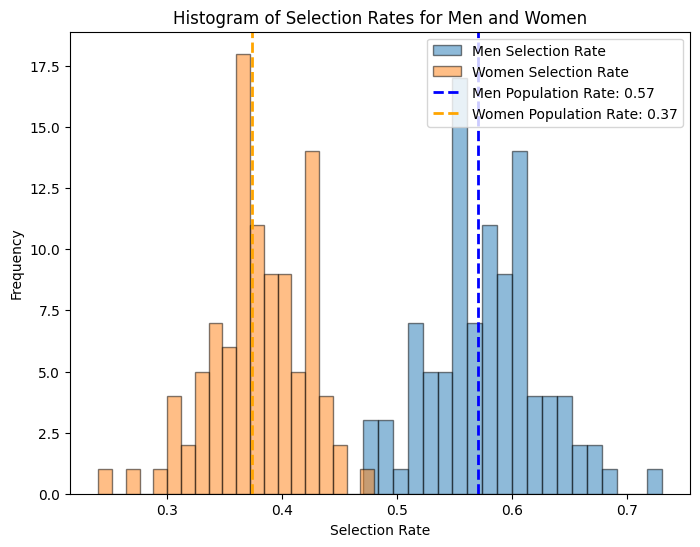

In [7]:
plot_sample_selection_rates(audit_metrics_df, pop_men_sel_rate=bias_population_metrics['men_selection_rate'],pop_women_sel_rate=bias_population_metrics['women_selection_rate'])

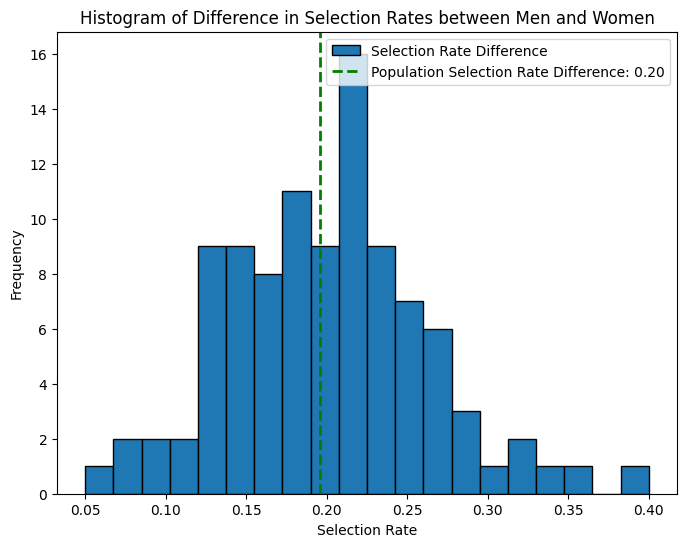

In [8]:
plot_hist_selection_rate_difference(audit_metrics_df, pop_sel_rate_difference=bias_population_metrics['difference_selection_rate'], sel_rate_thresh=sel_rate_thresh)

Number of significant p-vals for sel_rate_thresh: 84. Number of non-significant p-vals for sel_rate_thresh: 16


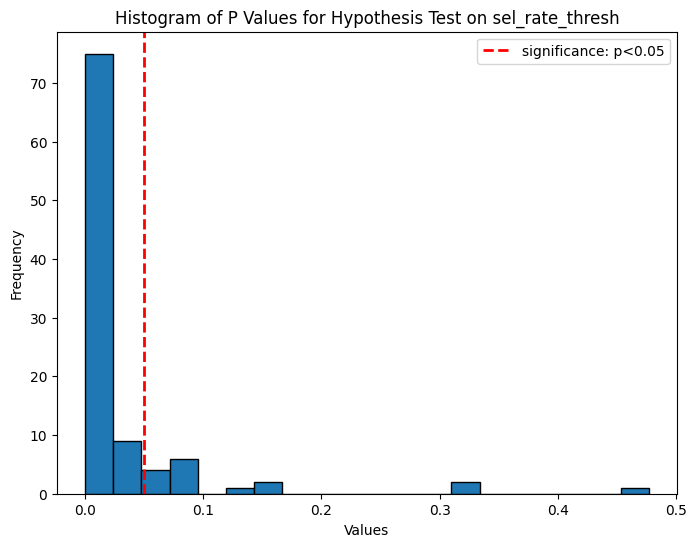

In [9]:
plot_p_values(audit_stats)

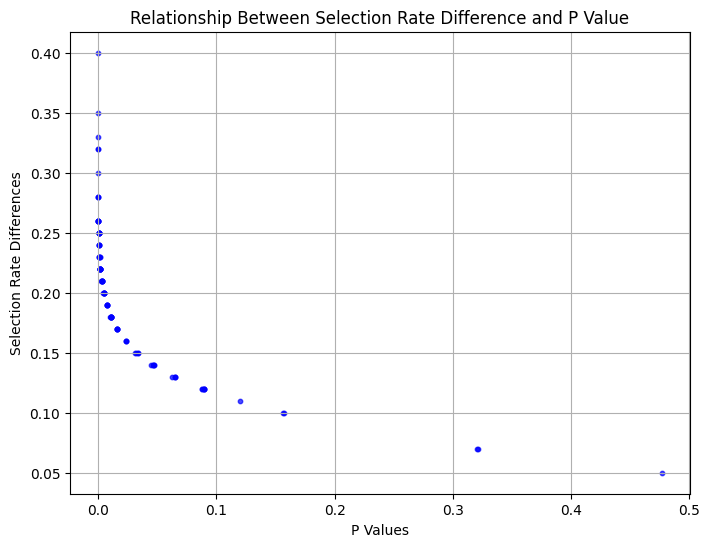

In [10]:
p_vals = [sample['p'] for sample in audit_stats]
sel_rate_differences = audit_metrics_df['difference_selection_rate'].values

plt.figure(figsize=(8, 6))  # Optional: set the figure size
plt.scatter(p_vals, sel_rate_differences, color='blue', marker='o', s=10, alpha=0.7)

# Add labels and title
plt.xlabel('P Values')
plt.ylabel('Selection Rate Differences')
plt.title('Relationship Between Selection Rate Difference and P Value')

# Optionally add a grid
plt.grid(True)

# Display the plot
plt.show()

Number of significant p-vals for sel_rate_thresh: 0. Number of non-significant p-vals for sel_rate_thresh: 100


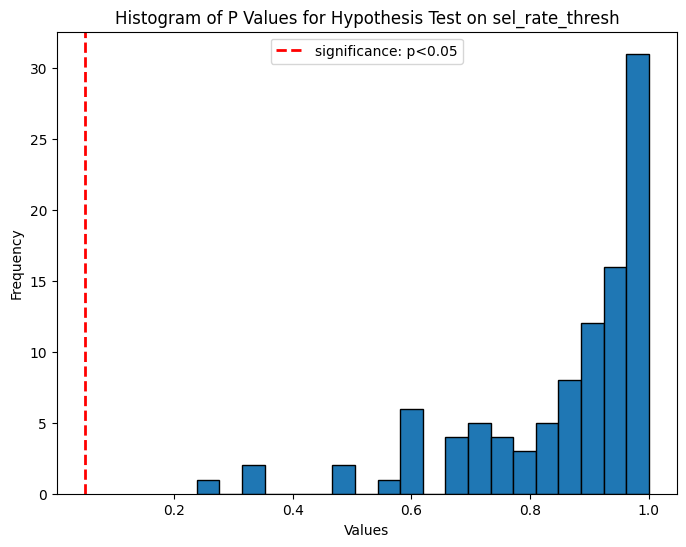

In [11]:
plot_p_values(audit_stats, non_inferiority=True)

In [12]:
audit_stats

[{'sample_num': 1,
  'z_stat': 3.677690873913362,
  'p': 0.00023535494577535938,
  'cohens_h_standard': 0.5261599602472913,
  'power_standard': 0.9810372558648232,
  'sample_size_standard': 44.66450743527505,
  'z_stat_noninf': 2.263194383946684,
  'p_noninf': 0.9881881453619646,
  'cohens_h_noninf': 0.7430205634435514,
  'power_noninf': 2.6221375288518935e-12,
  'sample_size_noninf': array([10.])},
 {'sample_num': 2,
  'z_stat': 2.5709039506801905,
  'p': 0.010143345475753258,
  'cohens_h_standard': 0.3657401616486191,
  'power_standard': 0.8267295152479868,
  'sample_size_standard': 92.43848862365513,
  'z_stat_noninf': 1.1426239780800844,
  'p_noninf': 0.8734026271764224,
  'cohens_h_noninf': 0.5868616250499332,
  'power_noninf': 3.4243741555672795e-09,
  'sample_size_noninf': array([10.])},
 {'sample_num': 3,
  'z_stat': 1.8459690064405705,
  'p': 0.06489670579748036,
  'cohens_h_standard': 0.2618251448507831,
  'power_standard': 0.5818114268273262,
  'sample_size_standard': 180.37